In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline

In [2]:
# Set a seed for the random number generator for reproducibility
np.random.seed(23)

# Number of samples
ns = np.linspace(0, 200, 1000)

# Source matrix
S = np.array([np.sin(ns * 1), 
              signal.sawtooth(ns * 1.9),
              np.random.random(len(ns))]).T

# Mixing matrix
A = np.array([[0.5, 1, 0.2], 
              [1, 0.5, 0.4], 
              [0.5, 0.8, 1]])

# Mixed signal matrix
X = S.dot(A).T

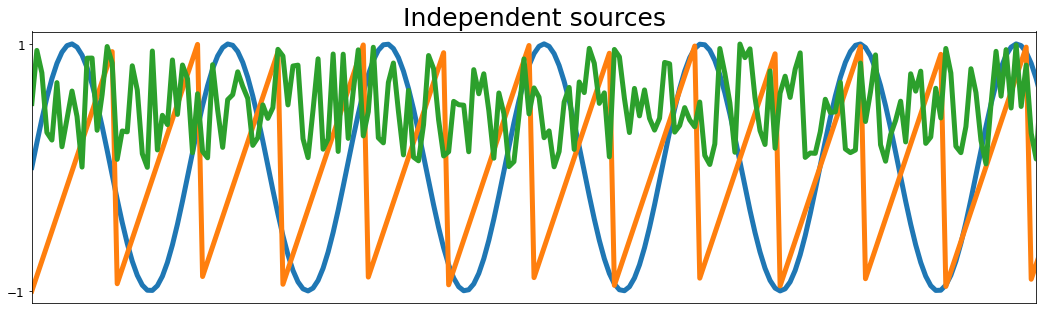

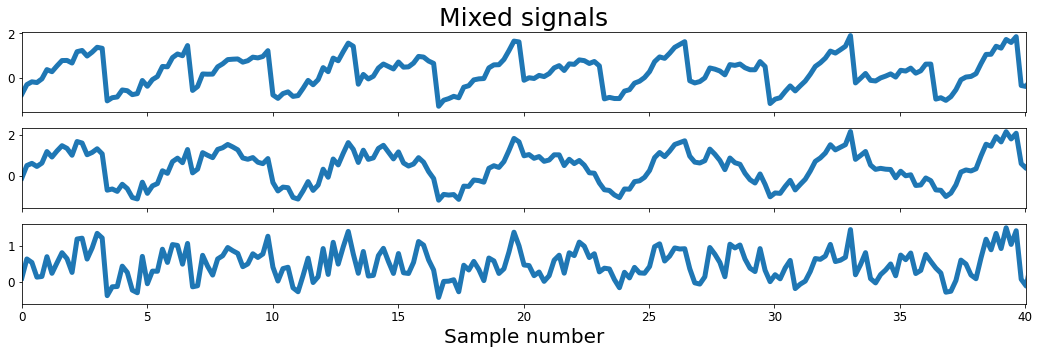

In [3]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(ns, S, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[200])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(ns, X[0], lw=5)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(ns, X[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(ns[0], ns[-1])

ax[2].plot(ns, X[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(ns[0], ns[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(ns[0], ns[200])

plt.show()

In [4]:
# Define two non-gaussian uniform components
s1 = np.random.rand(1000)
s2 = np.random.rand(1000)
s = np.array(([s1, s2]))

# Define two gaussian components
s1n = np.random.normal(size=1000)
s2n = np.random.normal(size=1000)
sn = np.array(([s1n, s2n]))

# Define orthogonal mixing matrix
A = np.array(([0.96, -0.28],[0.28, 0.96]))

# Mix signals
mixedSignals = s.T.dot(A)
mixedSignalsN = sn.T.dot(A)

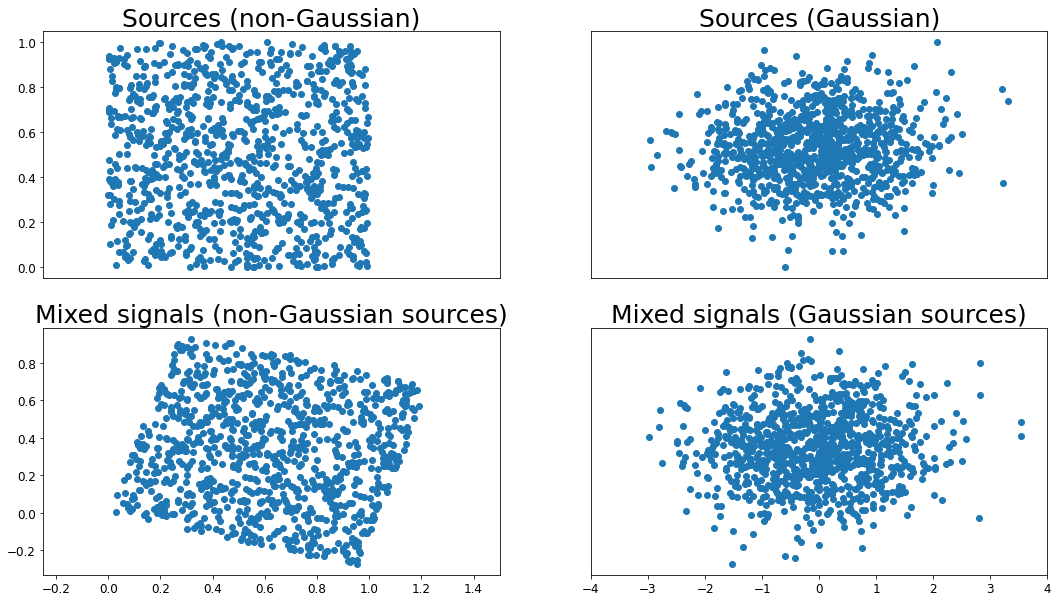

In [5]:
# Plot results
fig, ax = plt.subplots(2, 2, figsize=[18, 10])
ax[0][0].scatter(s[0], s[1])
ax[0][0].tick_params(labelsize=12)
ax[0][0].set_title('Sources (non-Gaussian)', fontsize=25)
ax[0][0].set_xlim([-0.25, 1.5])
ax[0][0].set_xticks([])

ax[0][1].scatter(sn[0], sn[1])
ax[0][1].tick_params(labelsize=12)
ax[0][1].set_title('Sources (Gaussian)', fontsize=25)
ax[0][1].set_xlim([-4, 4])
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

ax[1][0].scatter(mixedSignals.T[0], mixedSignals.T[1])
ax[1][0].tick_params(labelsize=12)
ax[1][0].set_title('Mixed signals (non-Gaussian sources)', fontsize=25)
ax[1][0].set_xlim([-0.25, 1.5])

ax[1][1].scatter(mixedSignalsN.T[0], mixedSignalsN.T[1])
ax[1][1].tick_params(labelsize=12)
ax[1][1].set_title('Mixed signals (Gaussian sources)', fontsize=25)
ax[1][1].set_xlim([-4, 4])
ax[1][1].set_yticks([])

plt.show()

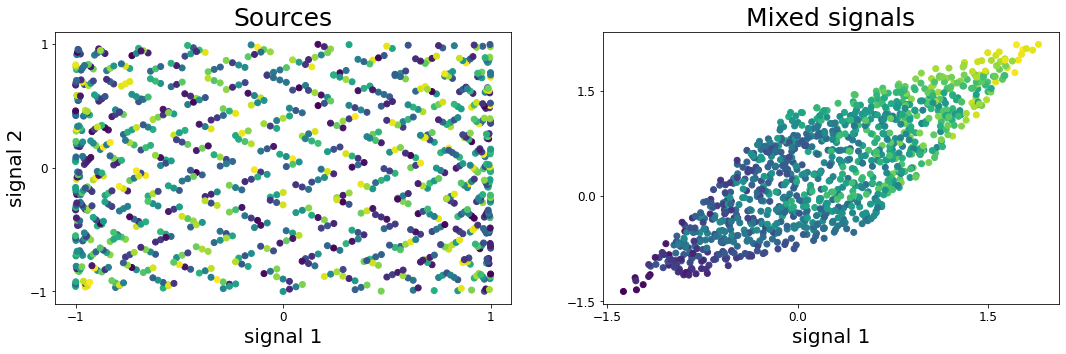

In [6]:
fig, ax = plt.subplots(1, 2, figsize=[18, 5])
ax[0].scatter(S.T[0], S.T[1], c=S.T[2])
ax[0].tick_params(labelsize=12)
ax[0].set_yticks([-1, 0, 1])
ax[0].set_xticks([-1, 0, 1])
ax[0].set_xlabel('signal 1', fontsize=20)
ax[0].set_ylabel('signal 2', fontsize=20)
ax[0].set_title('Sources', fontsize=25)

ax[1].scatter(X[0], X[1], c=X[2])
ax[1].tick_params(labelsize=12)
ax[1].set_yticks([-1.5, 0, 1.5])
ax[1].set_xticks([-1.5, 0, 1.5])
ax[1].set_xlabel('signal 1', fontsize=20)
ax[1].set_title('Mixed signals', fontsize=25)
plt.show()

In [7]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean 
    return centered, mean

In [8]:
def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

In [9]:
def whiten(x):
    # Calculate the covariance matrix
    coVarM = covariance(X) 
    
    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)
    
    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S)) 
    
    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))
    
    # Project onto whitening matrix
    Xw = np.dot(whiteM, X) 
    
    return Xw, whiteM

In [10]:
def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=5000):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):

                # Dot product of weight and signal
                ws = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                wg = np.tanh(ws * alpha).T

                # Pass w*s into g prime 
                wg_ = (1 - np.square(np.tanh(ws))) * alpha

                # Update weights
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights              
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)
                
                # Update weights
                w = wNew
                
                # Update counter
                i += 1

            W[c, :] = w.T
    return W

In [11]:
# Center signals
Xc, meanX = center(X)

# Whiten mixed signals
Xw, whiteM = whiten(Xc)

In [12]:
# Check if covariance of whitened matrix equals identity matrix
print(np.round(covariance(Xw)))

[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]


In [13]:
W = fastIca(Xw,  alpha=1)

#Un-mix signals using 
unMixed = Xw.T.dot(W.T)

# Subtract mean
unMixed = (unMixed.T - meanX).T

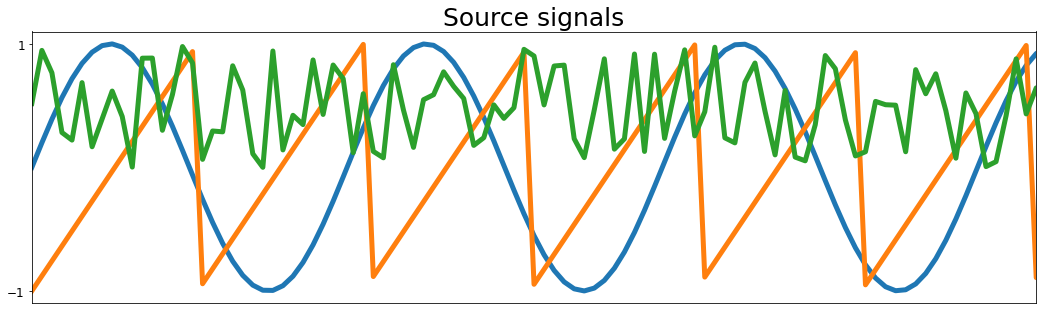

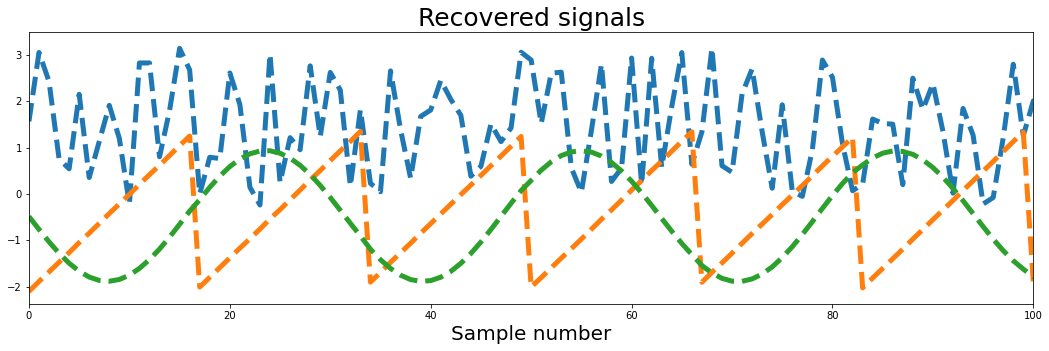

In [14]:
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(unMixed, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()

In [15]:
# Calculate Kurtosis

def kurt(x):
    n = np.shape(x)[0]
    mean = np.sum((x**1)/n) # Calculate the mean
    var = np.sum((x-mean)**2)/n # Calculate the variance
    skew = np.sum((x-mean)**3)/n # Calculate the skewness
    kurt = np.sum((x-mean)**4)/n # Calculate the kurtosis
    kurt = kurt/(var**2)-3

    return kurt, skew, var, mean

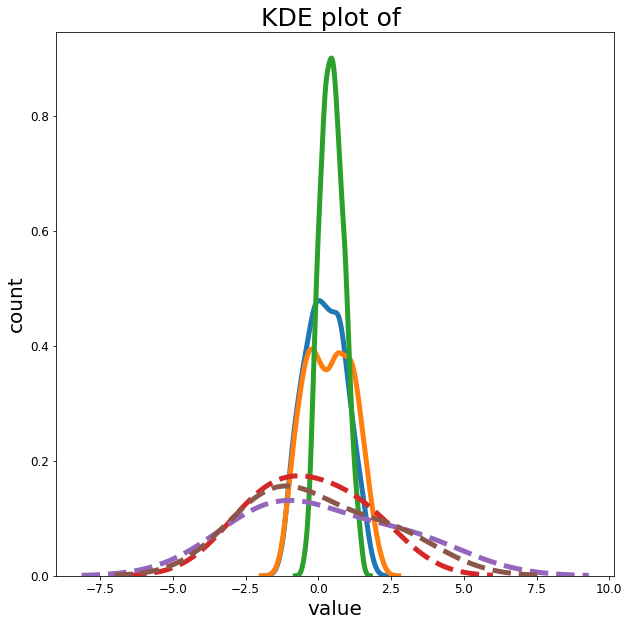

In [16]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10,10))
for i in range(X.shape[0]):
    
    sns.kdeplot(X[i, :], lw=5, label='Mixed Kurtosis={}'.format(np.round(kurt(X[i, :])[0], decimals=1)))
    
for i in range(X.shape[0]):   
    sns.kdeplot(unMixed[i, :], lw=5, ls='--', label='unMixed Kurtosis={}'.format(np.around(kurt(unMixed[i, :])[0], decimals=1)))

ax.tick_params(labelsize=12)
ax.set_xlabel('value', fontsize=20)
ax.set_ylabel('count', fontsize=20)
ax.set_title('KDE plot of ', fontsize=25)
plt.show()